<a href="https://colab.research.google.com/github/Dinhthixuanbinh/MINI_code/blob/main/Temperature-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
#from xgboost import XGBRegressor

# Utils

In [ ]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f"Offset will be change from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        # Load the data
        self.df = pl.read_csv(file_path)
        if date_column is not None: self.df = self.df.drop('Date Time', 'Tpot (K)', 'Tdew (degC)').head(10000)
        #if date_column is not None: self.df = self.df[['p (mbar)', 'T (degC)', 'rh (%)', 'VPdef (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'wd (deg)']].head(50000)

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape = }')
        print(f'{self.y_train.shape = }')
        self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape = }')
        print(f'{self.y_val.shape = }')
        self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape = }')
        print(f'{self.y_test.shape = }')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns

        return np.array(features), np.array(labels)

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).cuda()
        y_tensor = torch.tensor(y, dtype=torch.float32).cuda()
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model.cuda() if torch.cuda.is_available() else model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
           predictions = []
           with torch.no_grad():
               for inputs, _ in input_data:
                   outputs = self.model(inputs)
                   predictions.append(outputs)
           predictions = torch.cat(predictions, dim=0)
        else:
           # Assume input_data is a single input tensor
           with torch.no_grad():
               predictions = self.model(input_data).unsqueeze(0)

        return predictions


    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn't exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images

# Models

## LSTM

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM layers and ReLU activation
        self.lstm1 = nn.LSTM(input_size, 256, num_layers=1, batch_first=True)
        self.relu1 = nn.ReLU()
        self.lstm2 = nn.LSTM(256, 128, num_layers=1, batch_first=True)
        self.relu2 = nn.ReLU()
        self.lstm3 = nn.LSTM(128, 64, num_layers=1, batch_first=True)
        # Output layer
        self.dense = nn.Linear(64, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states for each LSTM layer
        h0_1 = torch.zeros(1, x.size(0), 256).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), 256).to(x.device)
        h0_2 = torch.zeros(1, x.size(0), 128).to(x.device)
        c0_2 = torch.zeros(1, x.size(0), 128).to(x.device)
        h0_3 = torch.zeros(1, x.size(0), 64).to(x.device)
        c0_3 = torch.zeros(1, x.size(0), 64).to(x.device)

        # Forward propagate through each LSTM layer with ReLU activations
        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.relu1(out)
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.relu2(out)
        out, _ = self.lstm3(out, (h0_3, c0_3))

        # Get the last time step's output
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.dense(out).view(-1, self.ahead, self.output_size)
        return out


## BiLSTM

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


## Configs

In [ ]:
input_size = 336
label_size = 96
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 10000
patience = 20
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 10
target_name = 'T (degC)'
date_column = 'Date Time'
file_path = '/content/drive/MyDrive/AIO/jena_climate_2009_2016.csv'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

# **Multivariate-to-Univartiate**

In [ ]:
features_type='MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape = (6568, 336, 12)
self.y_train.shape = (6568, 96, 1)
self.X_val.shape = (567, 336, 12)
self.y_val.shape = (567, 96, 1)
self.X_test.shape = (1377, 336, 12)
self.y_test.shape = (1377, 96, 1)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# LSTM

In [ ]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2uni_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights/multi2uni/best-LSTM.pth
Epoch [1/10000], time: 2s, loss: 30.1600, val_loss: 41.7026
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [2/10000], time: 2s, loss: 75.3385, val_loss: 26.3434
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [3/10000], time: 2s, loss: 79.1328, val_loss: 21.9741
Epoch [4/10000], time: 2s, loss: 73.3190, val_loss: 24.2808
Epoch [5/10000], time: 2s, loss: 78.1263, val_loss: 22.6239
Epoch [6/10000], time: 2s, loss: 76.5841, val_loss: 22.5223
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [7/10000], time: 3s, loss: 77.3332, val_loss: 21.0727
Epoch [8/10000], time: 2s, loss: 77.3174, val_loss: 21.9387
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [9/10000], time: 2s, loss: 76.9498, val_loss: 20.7767
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [10/10000], time: 2s, loss: 78.0871, val_loss: 20.2454
Model saved to weights/multi2uni/best-LSTM.pth
Epoch [11/10000], time: 2s, loss: 78.2337, val_loss: 19.7944
Model sav

{'Name': 'LSTM', 'Type': 'multi2uni', 'MSE': 99.35109443405048}

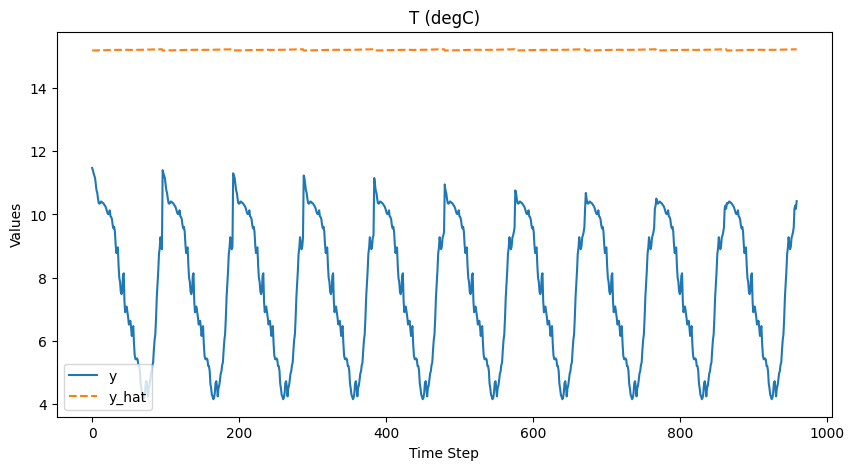

In [ ]:
LSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                            yhat=LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).cpu(),
                            feature_names=multi2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

# BiLSTM

In [ ]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable,
                          hidden_size=hidden_size,
                          output_size=multi2uni_loader.out_variable,
                          ahead=label_size,
                          num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs,
                               save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MSE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [1/10000], time: 5s, loss: 26.5886, val_loss: 47.7615
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [2/10000], time: 5s, loss: 57.1905, val_loss: 37.4102
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [3/10000], time: 5s, loss: 70.5827, val_loss: 31.4641
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [4/10000], time: 5s, loss: 72.9066, val_loss: 29.5480
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [5/10000], time: 5s, loss: 73.5742, val_loss: 27.6162
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [6/10000], time: 5s, loss: 73.8396, val_loss: 27.0059
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [7/10000], time: 5s, loss: 73.9588, val_loss: 26.7103
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [8/10000], time: 5s, loss: 74.0185, val_loss: 26.5366
Model saved to weights/multi2uni/best-BiLSTM.pth
Epoch [9/10000], time: 5s, loss: 74.0540, val_loss: 26.4299
Model saved to weig

{'Name': 'BiLSTM', 'Type': 'multi2uni', 'MSE': 130.83643673228568}

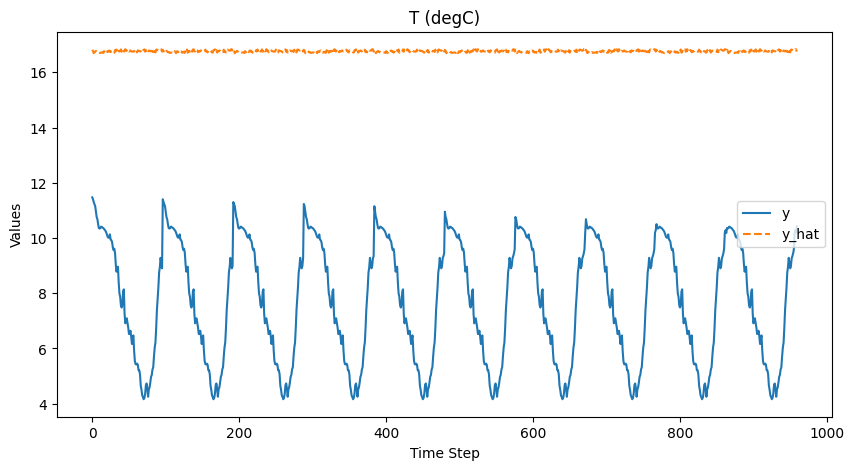

In [ ]:
BiLSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                              yhat=BiLSTM_multi2uni_manager.predict(multi2uni_loader.test_loader).cpu(),
                              feature_names=multi2uni_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# ubah menjadi hourly dan drop kolom yang tidak diperlukan
df= df[df['Date Time'].dt.minute==0].reset_index(drop=True).drop(columns=['Tpot (K)','Tdew (degC)'])
df.head()

,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [ ]:
input_= df[[i for i in df.columns if i not in ['Date Time']]]
target = df['T (degC)'].to_numpy() # kita akan prediksi Temperatur

# data time series tidak boleh di shuffle. pastikan shuffle = False
X, X_test, y, y_test = train_test_split(input_, target, test_size=0.1, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(53619, 12) (9463, 12) (7010, 12)
(53619,) (9463,) (7010,)


In [ ]:
# scaling data
preprocessing= ColumnTransformer([
    ('pipe',make_pipeline(StandardScaler()), list(input_.columns))
    ])

X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)
X_test_scaled = preprocessing.transform(X_test)

In [ ]:
# window = 24. artinya dalam 24 jam, kita mencoba untuk prediksi temperatur 1 jam berikutnya
window_len = 336
batch_size = 64
train_gen = TimeseriesGenerator(data=X_train_scaled, targets=y_train, length=window_len, shuffle=False, batch_size=batch_size)
val_gen = TimeseriesGenerator(data=X_val_scaled, targets=y_val, length=window_len, shuffle=False, batch_size=batch_size)
test_gen=TimeseriesGenerator(data=X_test_scaled, targets=y_test, length=window_len, shuffle=False, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_len, len(input_.columns)), return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

# learning rate scheduler
num_epochs = 1000
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 336, 256)          275456    
                                                                 
 re_lu_2 (ReLU)              (None, 336, 256)          0         
                                                                 
 lstm_4 (LSTM)               (None, 336, 128)          197120    
                                                                 
 re_lu_3 (ReLU)              (None, 336, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 522049 (1.99 MB)
Trainable params: 52204

In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/1000
833/833 [==============================] - 55s 60ms/step - loss: 67.0915 - root_mean_squared_error: 8.1909 - val_loss: 92.2271 - val_root_mean_squared_error: 9.6035
Epoch 2/1000
833/833 [==============================] - 50s 59ms/step - loss: 29.9749 - root_mean_squared_error: 5.4749 - val_loss: 7.8444 - val_root_mean_squared_error: 2.8008
Epoch 3/1000
833/833 [==============================] - 49s 59ms/step - loss: 3.8401 - root_mean_squared_error: 1.9596 - val_loss: 3.4868 - val_root_mean_squared_error: 1.8673
Epoch 4/1000
833/833 [==============================] - 49s 59ms/step - loss: 2.1129 - root_mean_squared_error: 1.4536 - val_loss: 2.3558 - val_root_mean_squared_error: 1.5349
Epoch 5/1000
833/833 [==============================] - 49s 59ms/step - loss: 1.0349 - root_mean_squared_error: 1.0173 - val_loss: 1.6245 - val_root_mean_squared_error: 1.2746
Epoch 6/1000
833/833 [==============================] - 49s 58ms/step - loss: 0.7918 - root_mean_squared_error: 0.889

In [ ]:
# save model
model.save('lstm_temperature.h5')

# load model
new_model = tf.keras.models.load_model('lstm_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred = new_model.predict(test_gen).flatten()

105/105 [==============================] - 3s 23ms/step


In [ ]:
df_result = X_test[window_len:].copy()
df_result['pred'] =  pred
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63418,2016-03-25 21:00:00,4.90,4.960940
63419,2016-03-25 22:00:00,4.70,4.804784
63420,2016-03-25 23:00:00,4.67,4.650156
63421,2016-03-26 00:00:00,4.77,4.658557
63422,2016-03-26 01:00:00,5.19,4.874479


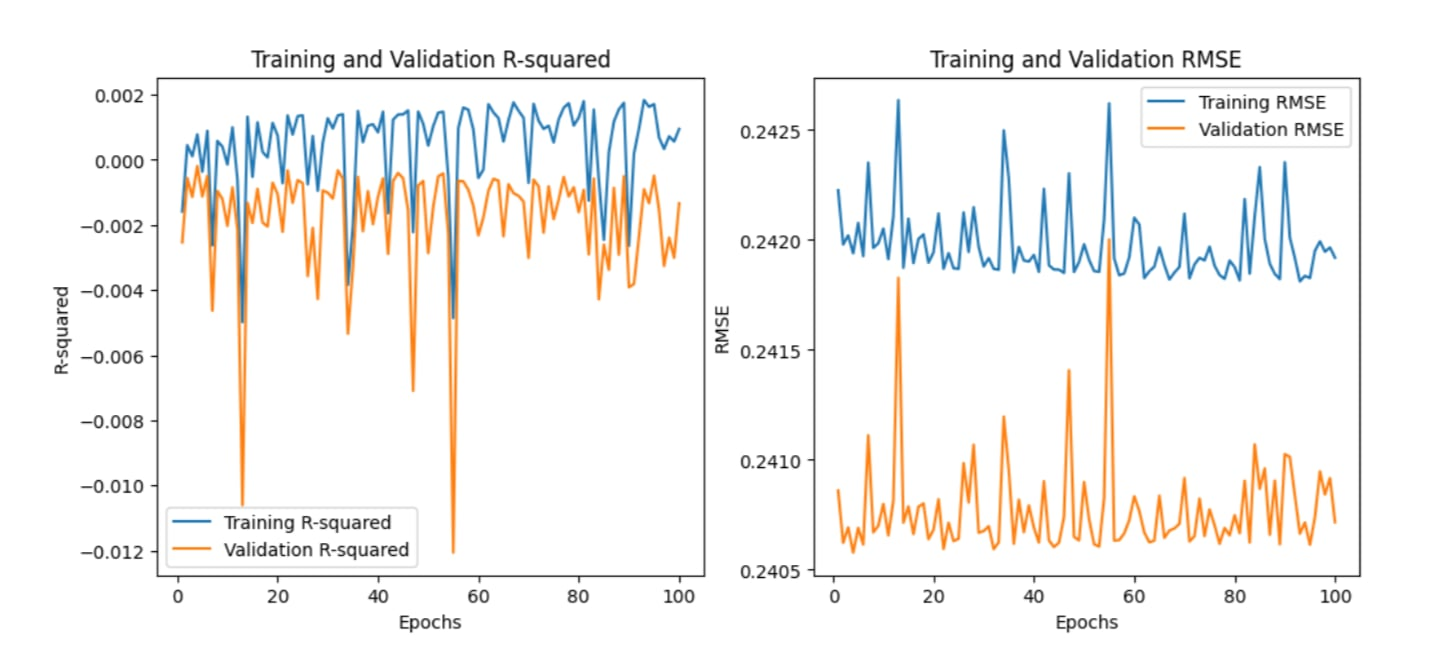

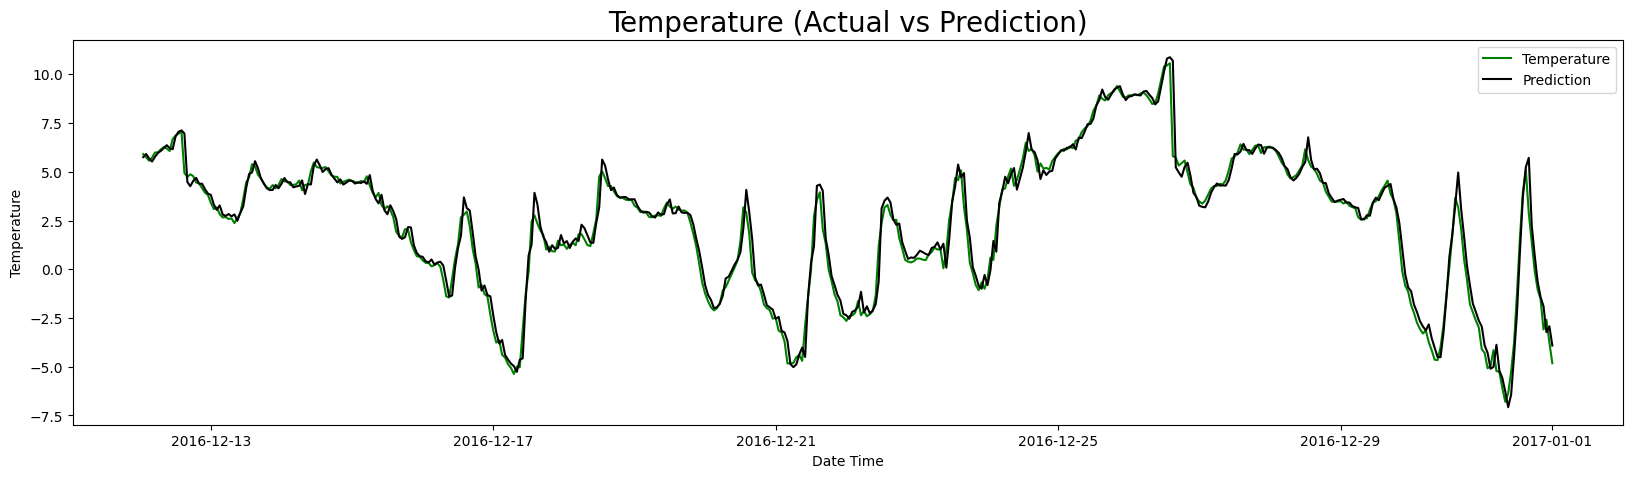

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [ ]:
print('R2 :',r2_score(y_true=df_result['Temperature'], y_pred=df_result['Prediction']))
print('RMSE :',mean_squared_error(y_true=df_result['Temperature'], y_pred=df_result['Prediction'],squared=False))

R2 : 0.9909734544110687
RMSE : 0.7420608861062237
